# Base Model

## 準備

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %pip install -q catboost

In [3]:
# ====================================================
# Library
# ====================================================
import os
import gc
import warnings

warnings.filterwarnings("ignore")
import random
import scipy as sp
import numpy as np
import pandas as pd
import polars as pl
from glob import glob
from pathlib import Path
import joblib
import pickle
import itertools
from tqdm.auto import tqdm

import torch
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GroupKFold
from sklearn.metrics import log_loss, roc_auc_score, matthews_corrcoef, f1_score
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error,
    mean_squared_log_error,
)
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import xgboost as xgb
from catboost import Pool, CatBoostRegressor, CatBoostClassifier
import time

In [4]:
# ====================================================
# Configurations
# ====================================================
class CFG:
    VER = 1
    AUTHOR = "Jun-Morita"
    COMPETITION = "houseprices"
    MAIN_PATH = Path.cwd()
    DATA_PATH = Path(f"{MAIN_PATH}/data")
    OOF_DATA_PATH = Path(f"{MAIN_PATH}/oof")
    MODEL_DATA_PATH = Path(f"{MAIN_PATH}/models")
    METHOD_LIST = ["lightgbm", "xgboost", "catboost"]
    METHOD_WEIGHT_DICT = {"lightgbm": 1 / 3, "xgboost": 1 / 3, "catboost": 1 / 3}
    USE_GPU = torch.cuda.is_available()
    SEED = 42
    N_SPLIT = 3
    target_col = "SalePrice"
    group_col = ""
    metric = "rmse"
    metric_maximize_flag = False

    num_boost_round = 2500
    early_stopping_round = 50
    verbose = 100

    lgb_params = {
        "objective": "regression",
        "metric": "rmse",  # '',
        "learning_rate": 0.05,
        "num_leaves": 6,
        "seed": SEED,
        "verbosity": -1,
    }

    xgb_params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",  # '',
        "learning_rate": 0.05,
        "max_depth": 3,
        "random_state": SEED,
    }

    cat_params = {
        "loss_function": "RMSE",
        "eval_metric": "RMSE",  #
        "learning_rate": 0.05,
        "iterations": num_boost_round,
        "depth": 3,
        "random_seed": SEED,
    }

In [5]:
# ====================================================
# Seed everything
# ====================================================
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)


seed_everything(CFG.SEED)

In [6]:
# ====================================================
# Timer
# ====================================================
from contextlib import contextmanager
from time import time


class Timer:
    def __init__(self, logger=None, format_str="{:.3f}[s]", prefix=None, suffix=None, sep=" "):
        if prefix:
            format_str = str(prefix) + sep + format_str
        if suffix:
            format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [7]:
def calc_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

## Read Data

In [8]:
# ====================================================
# Read Data
# ====================================================
# 基本的なデータ
train_df = pd.read_csv(CFG.DATA_PATH / "train.csv")
test_df = pd.read_csv(CFG.DATA_PATH / "test.csv")
submission_df = pd.read_csv(CFG.DATA_PATH / "sample_submission.csv")

<Axes: >

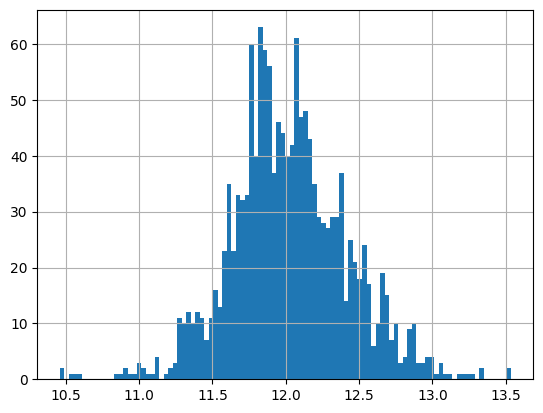

In [9]:
# 目的変数の対数化
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])
train_df["SalePrice"].hist(bins=100)

## EDA

In [10]:
display(train_df)
display(test_df)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247699
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109016
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317171
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849405
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,12.429220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,12.072547
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,12.254868
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,12.493133
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,11.864469


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [11]:
display(train_df.describe())
display(test_df.describe())

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,12.024057
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,0.399449
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,10.460271
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,11.775105
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,12.001512
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,12.273736
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,13.534474


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,...,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,...,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,...,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,...,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,...,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,...,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,...,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [12]:
display(train_df.describe(include="object"))
display(test_df.describe(include="object"))

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1455,1459,107,1459,1459,1457,1459,1459,1459,1459,...,1383,1381,1381,1381,1459,3,290,51,1458,1459
unique,5,2,2,4,4,1,5,3,25,9,...,6,3,4,5,3,2,4,3,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal
freq,1114,1453,70,934,1311,1457,1081,1396,218,1251,...,853,625,1293,1328,1301,2,172,46,1258,1204


In [13]:
display(train_df.isna().sum())
display(test_df.isna().sum())

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

Id                 0
MSSubClass         0
MSZoning           4
LotFrontage      227
LotArea            0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 80, dtype: int64

## Preprocessing data

In [14]:
def create_raw_features(input_df):
    df = input_df.copy()

    return df[
        [
            "LotArea",
            "OverallQual",
            "OverallCond",
            "BsmtFinSF1",
            "BsmtFinSF2",
            "BsmtUnfSF",
            "TotalBsmtSF",
            "TotRmsAbvGrd",
            "Fireplaces",
            "GarageYrBlt",
            "GarageCars",
            "GarageArea",
            "PoolArea",
            "MiscVal",
        ]
    ]

In [15]:
def create_quality_feature(input_df):
    df = input_df.copy()

    mapping = {
        "Ex": 5,  # Excellent
        "Gd": 4,  # Good
        "TA": 3,  # Typical/Average
        "Fa": 2,  # Fair
        "Po": 1,  # Poor
    }

    cols = [
        "ExterQual",
        "ExterCond",
        "BsmtQual",
        "BsmtCond",
        "HeatingQC",
        "KitchenQual",
        "FireplaceQu",
        "GarageQual",
        "GarageCond",
        "PoolQC",
    ]

    for col in cols:
        df[col] = df[col].map(mapping)  # 辞書にない値は NaN のまま

    return df[cols]

In [16]:
def create_mssubclass_feature(input_df):
    df = input_df.copy()

    mapping = {20: 20, 60: 60, 50: 50, 120: 120, 30: 30, 160: 160, 70: 70, 80: 80, 90: 90}
    df["MSSubClass"] = df["MSSubClass"].map(mapping).fillna(0).astype(int)

    return df[["MSSubClass"]]

In [17]:
def create_mszoning_feature(input_df):
    df = input_df.copy()

    mapping = {"RL": 1, "RM": 2, "FV": 3, "RH": 4, "C (all)": 5}
    df["MSZoning"] = df["MSZoning"].map(mapping).fillna(0).astype(int)

    return df[["MSZoning"]]

In [18]:
def create_lotfrontage_feature(input_df):
    df = input_df.copy()

    df["LotFrontage"] = df.groupby(["Neighborhood"])["LotFrontage"].transform(
        lambda x: x.fillna(x.median())
    )

    return df[["LotFrontage"]]

In [19]:
def create_street_alley_features(input_df):
    df = input_df.copy()

    mapping = {"Grvl": 1, "Pave": 0}

    # Street
    df["Street"] = df["Street"].map(mapping)

    # Alley（欠損値は NaN のまま残る）
    df["Alley"] = df["Alley"].map(mapping)

    return df[["Street", "Alley"]]

In [20]:
def create_lotshape_feature(input_df):
    df = input_df.copy()

    mapping = {"Reg": 1, "IR1": 2, "IR2": 3, "IR3": 4}
    df["LotShape"] = df["LotShape"].map(mapping).astype(int)

    return df[["LotShape"]]

In [21]:
def create_landcontour_feature(input_df):
    df = input_df.copy()

    mapping = {"Lvl": 1, "Bnk": 2, "HLS": 3, "Low": 4}
    df["LandContour"] = df["LandContour"].map(mapping).astype(int)

    return df[["LandContour"]]

In [22]:
def create_lotconfig_feature(input_df):
    df = input_df.copy()

    mapping = {"Inside": 1, "Corner": 2, "CulDSac": 3, "FR2": 4, "FR3": 5}
    df["LotConfig"] = df["LotConfig"].map(mapping).astype(int)

    return df[["LotConfig"]]

In [23]:
def create_landslope_feature(input_df):
    df = input_df.copy()

    mapping = {"Gtl": 1, "Mod": 2, "Sev": 3}
    df["LandSlope"] = df["LandSlope"].map(mapping).astype(int)

    return df[["LandSlope"]]

In [24]:
def create_neighborhood_feature(input_df):
    df = input_df.copy()

    mapping = {
        "Blmngtn": 1,
        "Blueste": 2,
        "BrDale": 3,
        "BrkSide": 4,
        "ClearCr": 5,
        "CollgCr": 6,
        "Crawfor": 7,
        "Edwards": 8,
        "Gilbert": 9,
        "IDOTRR": 10,
        "MeadowV": 11,
        "Mitchel": 12,
        "NAmes": 13,
        "NoRidge": 14,
        "NPkVill": 15,
        "NridgHt": 16,
        "NWAmes": 17,
        "OldTown": 18,
        "SWISU": 19,
        "Sawyer": 20,
        "SawyerW": 21,
        "Somerst": 22,
        "StoneBr": 23,
        "Timber": 24,
        "Veenker": 25,
    }

    df["Neighborhood"] = df["Neighborhood"].map(mapping).astype("Int64")

    return df[["Neighborhood"]]

In [25]:
def create_condition1_feature(input_df):
    df = input_df.copy()

    mapping = {
        "Norm": 1,
        "Feedr": 2,
        "Artery": 3,
        "RRAn": 4,
        "PosN": 5,
        "RRAe": 6,
        "PosA": 7,
        "RRNn": 8,
        "RRNe": 9,
    }
    df["Condition1"] = df["Condition1"].map(mapping).astype(int)

    return df[["Condition1"]]

In [26]:
def create_bldgtype_feature(input_df):
    df = input_df.copy()

    mapping = {"1Fam": 1, "TwnhsE": 2, "Duplex": 3, "Twnhs": 4, "2fmCon": 5}
    df["BldgType"] = df["BldgType"].map(mapping).astype(int)

    return df[["BldgType"]]

In [27]:
def create_housestyle_feature(input_df):
    df = input_df.copy()

    mapping = {
        "1Story": 1,
        "1.5Fin": 2,
        "1.5Unf": 3,
        "2Story": 4,
        "2.5Fin": 5,
        "2.5Unf": 6,
        "SFoyer": 7,
        "SLvl": 8,
    }
    df["HouseStyle"] = df["HouseStyle"].map(mapping).astype(int)

    return df[["HouseStyle"]]

In [28]:
def create_year_feature(input_df):
    df = input_df.copy()

    df["Year"] = df["YearBuilt"] + df["YearRemodAdd"]

    return df[["Year"]]

In [29]:
def create_roofstyle_feature(input_df):
    df = input_df.copy()

    mapping = {"Flat": 1, "Gable": 2, "Gambrel": 3, "Hip": 4, "Mansard": 5, "Shed": 6}
    df["RoofStyle"] = df["RoofStyle"].map(mapping).astype(int)

    return df[["RoofStyle"]]

In [30]:
def create_exterior1st_feature(input_df):
    df = input_df.copy()

    mapping = {
        "VinylSd": 1,
        "HdBoard": 2,
        "MetalSd": 3,
        "Wd Sdng": 4,
        "Plywood": 5,
        "CemntBd": 6,
        "BrkFace": 7,
    }
    df["Exterior1st"] = df["Exterior1st"].map(mapping).fillna(0).astype(int)

    return df[["Exterior1st"]]

In [31]:
def create_masvnrtype_feature(input_df):
    df = input_df.copy()

    mapping = {
        "BrkFace": 1,
        "Stone": 2,
        "BrkCmn": 3,
    }
    df["MasVnrType"] = df["MasVnrType"].map(mapping).fillna(0).astype(int)

    return df[["MasVnrType"]]

In [32]:
def create_masvnrarea_feature(input_df):
    df = input_df.copy()

    df["MasVnrArea"] = df.groupby(["Neighborhood"])["MasVnrArea"].transform(
        lambda x: x.fillna(x.median())
    )

    return df[["MasVnrArea"]]

In [33]:
def create_foundation_feature(input_df):
    df = input_df.copy()

    mapping = {"PConc": 1, "CBlock": 2, "BrkTil": 3, "Slab": 4, "Stone": 5, "Wood": 6}

    df["Foundation"] = df["Foundation"].map(mapping).fillna(0).astype(int)

    return df[["Foundation"]]

In [34]:
def create_bsmtexposure_feature(input_df):
    df = input_df.copy()

    mapping = {"Gd": 1, "Av": 2, "Mn": 3, "No": 4}

    df["BsmtExposure"] = df["BsmtExposure"].map(mapping)

    return df[["BsmtExposure"]]

In [35]:
def create_bsmtfintype1_feature(input_df):
    df = input_df.copy()

    mapping = {"GLQ": 1, "ALQ": 2, "BLQ": 3, "Rec": 4, "LwQ": 5, "Unf": 6}

    df["BsmtFinType1"] = df["BsmtFinType1"].map(mapping).fillna(0).astype(int)

    return df[["BsmtFinType1"]]

In [36]:
def create_bsmtfintype2_feature(input_df):
    df = input_df.copy()

    mapping = {"GLQ": 1, "ALQ": 2, "BLQ": 3, "Rec": 4, "LwQ": 5, "Unf": 6}

    df["BsmtFinType2"] = df["BsmtFinType2"].map(mapping).fillna(0).astype(int)

    return df[["BsmtFinType2"]]

In [37]:
def create_centralair_feature(input_df):
    df = input_df.copy()

    mapping = {"Y": 1, "N": 0}

    df["CentralAir"] = df["CentralAir"].map(mapping).fillna(0).astype(int)

    return df[["CentralAir"]]

In [38]:
def create_electrical_feature(input_df):
    df = input_df.copy()

    mapping = {"SBrkr": 1, "FuseA": 2, "FuseF": 3}

    df["Electrical"] = df["Electrical"].map(mapping).fillna(0).astype(int)

    return df[["Electrical"]]

In [39]:
def create_2ndflr_feature(input_df):
    df = input_df.copy()

    df["2ndFlr"] = df["2ndFlrSF"].apply(lambda x: 1 if x > 0 else 0)

    return df[["2ndFlr"]]

In [40]:
def create_totalsf_feature(input_df):
    df = input_df.copy()

    df["TotalSF"] = df["1stFlrSF"] + df["2ndFlrSF"] + df["TotalBsmtSF"]

    return df[["TotalSF"]]

In [41]:
def create_baths_feature(input_df):
    df = input_df.copy()

    df["Baths"] = (
        df["FullBath"] + 0.5 * df["HalfBath"] + df["BsmtFullBath"] + 0.5 * df["BsmtHalfBath"]
    )

    return df[["Baths"]]

In [42]:
def create_sfperrms_feature(input_df):
    df = input_df.copy()

    df["TotalSF"] = df["1stFlrSF"] + df["2ndFlrSF"] + df["TotalBsmtSF"]
    df["SFPerRms"] = df["TotalSF"] / df["TotRmsAbvGrd"]

    return df[["SFPerRms"]]

In [43]:
def create_functional_feature(input_df):
    df = input_df.copy()

    mapping = {"Typ": 1, "Min1": 2, "Min2": 3, "Mod": 4, "Maj1": 5, "Maj2": 6, "Sev": 7, "Sal": 8}

    df["Functional"] = df["Functional"].map(mapping).fillna(1).astype(int)  # ほとんどがTypのため

    return df[["Functional"]]

In [44]:
def create_garagetype_feature(input_df):
    df = input_df.copy()

    mapping = {"2Types": 1, "Attchd": 2, "Basment": 3, "BuiltIn": 4, "CarPort": 5, "Detchd": 6}

    df["GarageType"] = df["GarageType"].map(mapping).fillna(0).astype(int)

    return df[["GarageType"]]

In [45]:
def create_garagefinish_feature(input_df):
    df = input_df.copy()

    mapping = {"Fin": 1, "RFn": 2, "Unf": 3}

    df["GarageFinish"] = df["GarageFinish"].map(mapping).fillna(0).astype(int)

    return df[["GarageFinish"]]

In [46]:
def create_paveddrive_feature(input_df):
    df = input_df.copy()

    mapping = {"Y": 1, "P": 2, "N": 3}

    df["PavedDrive"] = df["PavedDrive"].map(mapping)

    return df[["PavedDrive"]]

In [47]:
def create_porchsf_feature(input_df):
    df = input_df.copy()

    df["PorchSF"] = (
        df["OpenPorchSF"]
        + df["3SsnPorch"]
        + df["EnclosedPorch"]
        + df["ScreenPorch"]
        + df["WoodDeckSF"]
    )

    return df[["PorchSF"]]

In [48]:
def create_fence_feature(input_df):
    df = input_df.copy()

    mapping = {"GdPrv": 1, "MnPrv": 2, "GdWo": 3, "MnWw": 4}

    df["Fence"] = df["Fence"].map(mapping)

    return df[["Fence"]]

In [49]:
def create_saletype_feature(input_df):
    df = input_df.copy()

    mapping = {
        "WD": 1,
        "CWD": 2,
        "New": 3,
        "COD": 4,
        "Con": 5,
        "ConLw": 6,
        "ConLI": 7,
        "ConLD": 8,
        "Oth": 9,
    }

    df["SaleType"] = df["SaleType"].map(mapping).fillna(1).astype(int)

    return df[["SaleType"]]

In [50]:
def create_salecondition_feature(input_df):
    df = input_df.copy()

    mapping = {"Normal": 1, "Abnorml": 2, "AdjLand": 3, "Alloca": 4, "Family": 5, "Partial": 6}

    df["SaleCondition"] = df["SaleCondition"].map(mapping).fillna(1).astype(int)

    return df[["SaleCondition"]]

In [51]:
from typing import List


def build_feature(input_df: pd.DataFrame, feature_functions: List) -> pd.DataFrame:
    # 出力するデータフレームを空で用意して
    out_df = pd.DataFrame()

    print("start build features...")

    # 各特徴生成関数ごとで
    for func in feature_functions:
        with Timer(prefix=f"create {func.__name__}"):
            # 特徴量を作成し
            _df = func(input_df)

        # 横方向 (axis=1) にがっちゃんこ (concat) する
        out_df = pd.concat([out_df, _df], axis=1)

    return out_df

In [52]:
feature_functions = [
    create_raw_features,
    create_quality_feature,
    create_mssubclass_feature,
    create_mszoning_feature,
    create_lotfrontage_feature,
    create_street_alley_features,
    create_lotshape_feature,
    create_landcontour_feature,
    # Utilitiesは特徴量として使用せず
    create_lotconfig_feature,
    create_landslope_feature,
    create_neighborhood_feature,
    create_condition1_feature,
    # Condition2は特徴量として使用せず
    create_bldgtype_feature,
    create_housestyle_feature,
    create_year_feature,  # YearBuiltとYearRemodAddより
    create_roofstyle_feature,
    # RoofMatlは特徴量として使用せず
    create_exterior1st_feature,
    # Exterior2ndは特徴量として使用せず
    create_masvnrtype_feature,
    create_masvnrarea_feature,
    create_foundation_feature,
    create_bsmtexposure_feature,
    create_bsmtfintype1_feature,
    create_bsmtfintype2_feature,
    # Heatingは特徴量として使用せず
    create_centralair_feature,
    create_electrical_feature,
    create_2ndflr_feature,
    create_totalsf_feature,
    create_baths_feature,
    create_sfperrms_feature,
    create_functional_feature,
    create_garagetype_feature,
    create_garagefinish_feature,
    create_paveddrive_feature,
    create_porchsf_feature,
    create_fence_feature,
    # MiscFeatureは特徴量として使用せず
    create_saletype_feature,
    create_salecondition_feature,
]

In [53]:
feat_train_df = build_feature(input_df=train_df, feature_functions=feature_functions)
feat_test_df = build_feature(input_df=test_df, feature_functions=feature_functions)

train_full_df = pd.concat([train_df[CFG.target_col], feat_train_df], axis=1)

features = feat_train_df.columns.tolist()
categorical_features = [
    "MSSubClass",
    "MSZoning",
    "LandContour",
    "LotConfig",
    "Neighborhood",
    "Condition1",
    "BldgType",
    "HouseStyle",
    "RoofStyle",
    "Exterior1st",
    "MasVnrType",
    "Foundation",
    "Electrical",
    "GarageType",
    "GarageFinish",
    "SaleType",
    "SaleCondition",
]

display(features)
display(train_full_df)
display(feat_test_df)

start build features...
create create_raw_features 0.002[s]
create create_quality_feature 0.012[s]
create create_mssubclass_feature 0.002[s]
create create_mszoning_feature 0.002[s]
create create_lotfrontage_feature 0.014[s]
create create_street_alley_features 0.004[s]
create create_lotshape_feature 0.004[s]
create create_landcontour_feature 0.004[s]
create create_lotconfig_feature 0.004[s]
create create_landslope_feature 0.003[s]
create create_neighborhood_feature 0.003[s]
create create_condition1_feature 0.002[s]
create create_bldgtype_feature 0.003[s]
create create_housestyle_feature 0.003[s]
create create_year_feature 0.002[s]
create create_roofstyle_feature 0.002[s]
create create_exterior1st_feature 0.003[s]
create create_masvnrtype_feature 0.003[s]
create create_masvnrarea_feature 0.011[s]
create create_foundation_feature 0.003[s]
create create_bsmtexposure_feature 0.002[s]
create create_bsmtfintype1_feature 0.003[s]
create create_bsmtfintype2_feature 0.003[s]
create create_centra

['LotArea',
 'OverallQual',
 'OverallCond',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'PoolArea',
 'MiscVal',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'HeatingQC',
 'KitchenQual',
 'FireplaceQu',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'MSSubClass',
 'MSZoning',
 'LotFrontage',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'BldgType',
 'HouseStyle',
 'Year',
 'RoofStyle',
 'Exterior1st',
 'MasVnrType',
 'MasVnrArea',
 'Foundation',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'CentralAir',
 'Electrical',
 '2ndFlr',
 'TotalSF',
 'Baths',
 'SFPerRms',
 'Functional',
 'GarageType',
 'GarageFinish',
 'PavedDrive',
 'PorchSF',
 'Fence',
 'SaleType',
 'SaleCondition']

,SalePrice,LotArea,OverallQual,OverallCond,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,TotRmsAbvGrd,Fireplaces,...,Baths,SFPerRms,Functional,GarageType,GarageFinish,PavedDrive,PorchSF,Fence,SaleType,SaleCondition
0,12.247699,8450,7,5,706,0,150,856,8,0,...,3.5,320.750000,1,2,2,1,61,NaN,1,1
1,12.109016,9600,6,8,978,0,284,1262,6,1,...,2.5,420.666667,1,2,2,1,298,NaN,1,1
2,12.317171,11250,7,5,486,0,434,920,6,1,...,3.5,451.000000,1,2,2,1,42,NaN,1,1
3,11.849405,9550,7,5,216,0,540,756,7,1,...,2.0,353.285714,1,6,3,1,307,NaN,1,2
4,12.429220,14260,8,5,655,0,490,1145,9,1,...,3.5,371.444444,1,2,2,1,276,NaN,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,12.072547,7917,6,5,0,0,953,953,7,1,...,2.5,371.428571,1,2,2,1,40,NaN,1,1
1456,12.254868,13175,6,6,790,163,589,1542,7,2,...,3.0,516.428571,2,2,3,1,349,2.0,1,1
1457,12.493133,9042,7,9,275,0,877,1152,9,2,...,2.0,388.000000,1,2,2,1,60,1.0,1,1
1458,11.864469,9717,5,6,49,1029,0,1078,5,0,...,2.0,431.200000,1,2,3,1,478,NaN,1,1


,LotArea,OverallQual,OverallCond,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,TotRmsAbvGrd,Fireplaces,GarageYrBlt,...,Baths,SFPerRms,Functional,GarageType,GarageFinish,PavedDrive,PorchSF,Fence,SaleType,SaleCondition
0,11622,5,6,468.0,144.0,270.0,882.0,5,0,1961.0,...,1.0,355.600000,1,2,3,1,260,2.0,1,1
1,14267,6,6,923.0,0.0,406.0,1329.0,6,0,1958.0,...,1.5,443.000000,1,2,3,1,429,NaN,1,1
2,13830,5,5,791.0,0.0,137.0,928.0,6,1,1997.0,...,2.5,426.166667,1,2,1,1,246,2.0,1,1
3,9978,6,6,602.0,0.0,324.0,926.0,7,1,1998.0,...,2.5,361.428571,1,2,1,1,396,NaN,1,1
4,5005,8,5,263.0,0.0,1017.0,1280.0,5,0,1992.0,...,2.0,512.000000,1,2,2,1,226,NaN,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,1936,4,7,0.0,0.0,546.0,546.0,5,0,NaN,...,1.5,327.600000,1,0,0,1,0,NaN,1,1
1455,1894,4,5,252.0,0.0,294.0,546.0,6,0,1970.0,...,1.5,273.000000,1,5,3,1,24,NaN,1,2
1456,20000,5,7,1224.0,0.0,0.0,1224.0,7,1,1960.0,...,2.0,349.714286,1,6,3,1,474,NaN,1,2
1457,10441,5,5,337.0,0.0,575.0,912.0,6,0,NaN,...,1.5,313.666667,1,0,0,1,112,2.0,1,1


## Machine Learning

In [54]:
model_dict = {}


def lightgbm_training(
    x_train: pd.DataFrame,
    y_train: pd.DataFrame,
    x_valid: pd.DataFrame,
    y_valid: pd.DataFrame,
    features: list,
    categorical_features: list,
):
    lgb_train = lgb.Dataset(x_train, y_train, categorical_feature=categorical_features)
    lgb_valid = lgb.Dataset(x_valid, y_valid, categorical_feature=categorical_features)
    model = lgb.train(
        params=CFG.lgb_params,
        train_set=lgb_train,
        num_boost_round=CFG.num_boost_round,
        valid_sets=[lgb_train, lgb_valid],
        callbacks=[
            lgb.early_stopping(stopping_rounds=CFG.early_stopping_round, verbose=CFG.verbose),
            lgb.log_evaluation(CFG.verbose),
        ],
    )
    # Predict validation
    valid_pred = model.predict(x_valid)
    return model, valid_pred


def xgboost_training(
    x_train: pd.DataFrame,
    y_train: pd.DataFrame,
    x_valid: pd.DataFrame,
    y_valid: pd.DataFrame,
    features: list,
    categorical_features: list,
):
    xgb_train = xgb.DMatrix(data=x_train, label=y_train, enable_categorical=True)
    xgb_valid = xgb.DMatrix(data=x_valid, label=y_valid, enable_categorical=True)
    model = xgb.train(
        CFG.xgb_params,
        dtrain=xgb_train,
        num_boost_round=CFG.num_boost_round,
        evals=[(xgb_train, "train"), (xgb_valid, "eval")],
        early_stopping_rounds=CFG.early_stopping_round,
        verbose_eval=CFG.verbose,
    )
    # Predict validation
    valid_pred = model.predict(xgb.DMatrix(x_valid, enable_categorical=True))
    return model, valid_pred


def catboost_training(
    x_train: pd.DataFrame,
    y_train: pd.DataFrame,
    x_valid: pd.DataFrame,
    y_valid: pd.DataFrame,
    features: list,
    categorical_features: list,
):
    cat_train = Pool(data=x_train, label=y_train, cat_features=categorical_features)
    cat_valid = Pool(data=x_valid, label=y_valid, cat_features=categorical_features)
    # model = CatBoostClassifier(**CFG.cat_params)
    model = CatBoostRegressor(**CFG.cat_params)
    model.fit(
        cat_train,
        eval_set=[cat_valid],
        early_stopping_rounds=CFG.early_stopping_round,
        verbose=CFG.verbose,
        use_best_model=True,
    )
    # Predict validation
    # valid_pred = model.predict_proba(x_valid)[:, 1]
    valid_pred = model.predict(x_valid)
    return model, valid_pred


def gradient_boosting_model_cv_training(
    method: str, train_df: pd.DataFrame, features: list, categorical_features: list
):
    # Create a numpy array to store out of folds predictions
    oof_predictions = np.zeros(len(train_df))
    oof_fold = np.zeros(len(train_df))
    target_col = CFG.target_col

    # kfoldはタスクによって変更
    kfold = KFold(n_splits=CFG.N_SPLIT, shuffle=True, random_state=CFG.SEED)
    # kfold = StratifiedKFold(n_splits=CFG.N_SPLIT, shuffle=True, random_state=CFG.SEED)
    # kfold = GroupKFold(n_splits=CFG.N_SPLIT, shuffle=True, random_state=CFG.SEED)

    for fold, (train_index, valid_index) in enumerate(
        kfold.split(train_df[features], train_df[CFG.target_col])
    ):
        print("-" * 50)
        print(f"{method} training fold {fold+1}")
        x_train = train_df[features].iloc[train_index]
        y_train = train_df[target_col].iloc[train_index]
        x_valid = train_df[features].iloc[valid_index]
        y_valid = train_df[target_col].iloc[valid_index]
        if method == "lightgbm":
            model, valid_pred = lightgbm_training(
                x_train, y_train, x_valid, y_valid, features, categorical_features
            )
            importance_df = pd.DataFrame(
                model.feature_importance(), index=features, columns=["importance"]
            ).reset_index()
            importance_df.to_csv(
                CFG.MODEL_DATA_PATH
                / f"{CFG.AUTHOR}_{method}_{target_col}_fold{fold + 1}_seed{CFG.SEED}_ver{CFG.VER}_importance.csv",
                index=False,
            )
        if method == "xgboost":
            model, valid_pred = xgboost_training(
                x_train, y_train, x_valid, y_valid, features, categorical_features
            )
        if method == "catboost":
            model, valid_pred = catboost_training(
                x_train, y_train, x_valid, y_valid, features, categorical_features
            )
        # Save best model
        pickle.dump(
            model,
            open(
                CFG.MODEL_DATA_PATH
                / f"{CFG.AUTHOR}_{method}_{target_col}_fold{fold + 1}_seed{CFG.SEED}_ver{CFG.VER}.pkl",
                "wb",
            ),
        )
        model_dict[f"{method}_{target_col}_fold{fold+1}"] = model
        # Add to out of folds array
        oof_predictions[valid_index] = valid_pred
        del x_train, x_valid, y_train, y_valid, model, valid_pred
        gc.collect()
        oof_fold[valid_index] = fold + 1

    oof_df = pd.DataFrame(
        {
            CFG.target_col: oof_predictions.astype(float),
            "fold": oof_fold.astype(int),
            "row_id": train_df.index,
        }
    )

    y_true = train_df[CFG.target_col].values
    score = calc_score(y_true, oof_df[CFG.target_col].values)
    print(f"{method} our out of folds CV {CFG.metric} is {score}")

    oof_path = CFG.OOF_DATA_PATH / f"oof_{CFG.AUTHOR}_{method}_seed{CFG.SEED}_ver{CFG.VER}.csv"
    oof_df.to_csv(oof_path, index=False)

In [55]:
for method in CFG.METHOD_LIST:
    gradient_boosting_model_cv_training(method, train_full_df, features, categorical_features)

--------------------------------------------------
lightgbm training fold 1
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.103921	valid_1's rmse: 0.134033
[200]	training's rmse: 0.0854367	valid_1's rmse: 0.12958
Early stopping, best iteration is:
[194]	training's rmse: 0.0860886	valid_1's rmse: 0.129411
--------------------------------------------------
lightgbm training fold 2
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.100747	valid_1's rmse: 0.145021
[200]	training's rmse: 0.083716	valid_1's rmse: 0.141253
Early stopping, best iteration is:
[247]	training's rmse: 0.0793938	valid_1's rmse: 0.141077
--------------------------------------------------
lightgbm training fold 3
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.10838	valid_1's rmse: 0.121978
[200]	training's rmse: 0.0897977	valid_1's rmse: 0.120107
[300]	training's rmse: 0.0792624	valid_1's rmse: 0.119921
Ear

In [56]:
def lightgbm_inference(x_test: pd.DataFrame, target_col: str):
    test_pred = np.zeros(len(x_test))
    for fold in range(CFG.N_SPLIT):
        model = pickle.load(
            open(
                CFG.MODEL_DATA_PATH
                / f"{CFG.AUTHOR}_lightgbm_{target_col}_fold{fold + 1}_seed{CFG.SEED}_ver{CFG.VER}.pkl",
                "rb",
            )
        )

        # Predict
        pred = model.predict(x_test)
        test_pred += pred
    return test_pred / CFG.N_SPLIT


def xgboost_inference(x_test: pd.DataFrame, target_col: str):
    test_pred = np.zeros(len(x_test))
    for fold in range(CFG.N_SPLIT):
        model = pickle.load(
            open(
                CFG.MODEL_DATA_PATH
                / f"{CFG.AUTHOR}_xgboost_{target_col}_fold{fold + 1}_seed{CFG.SEED}_ver{CFG.VER}.pkl",
                "rb",
            )
        )
        # Predict
        pred = model.predict(xgb.DMatrix(x_test, enable_categorical=True))
        test_pred += pred
    return test_pred / CFG.N_SPLIT


def catboost_inference(x_test: pd.DataFrame, target_col: str):
    test_pred = np.zeros(len(x_test))
    for fold in range(CFG.N_SPLIT):
        model = pickle.load(
            open(
                CFG.MODEL_DATA_PATH
                / f"{CFG.AUTHOR}_catboost_{target_col}_fold{fold + 1}_seed{CFG.SEED}_ver{CFG.VER}.pkl",
                "rb",
            )
        )
        # Predict
        # pred = model.predict_proba(x_test)[:, 1]
        pred = model.predict(x_test)
        test_pred += pred
    return test_pred / CFG.N_SPLIT


def gradient_boosting_model_inference(
    method: str, target_col: str, test_df: pd.DataFrame, features: list
):
    x_test = test_df[features]
    if method == "lightgbm":
        test_pred = lightgbm_inference(x_test, target_col)
    if method == "xgboost":
        test_pred = xgboost_inference(x_test, target_col)
    if method == "catboost":
        test_pred = catboost_inference(x_test, target_col)
    return test_pred


def predicting(input_df: pd.DataFrame, features: list):
    output_df = input_df.copy()
    target_col = CFG.target_col
    print(f"{target_col} inference")
    output_df[f"{target_col}"] = 0
    for method in CFG.METHOD_LIST:
        output_df[f"{method}_{target_col}_pred"] = gradient_boosting_model_inference(
            method, target_col, input_df, features
        )
        output_df[f"{target_col}"] += (
            output_df[f"{method}_{target_col}_pred"] * CFG.METHOD_WEIGHT_DICT[method]
        )
    return output_df

In [57]:
def eval_single_oof_from_file(method: str, train_df: pd.DataFrame) -> float:
    """単一メソッドの OOF を読み込んで calc_score を計算"""
    path = CFG.OOF_DATA_PATH / f"oof_{CFG.AUTHOR}_{method}_seed{CFG.SEED}_ver{CFG.VER}.csv"
    oof = pd.read_csv(path)

    # row_id を元に行順を揃える
    if "row_id" not in oof.columns:
        raise ValueError(f"OOF file for {method} has no 'row_id'. 学習部①を修正してください。")
    oof = oof.set_index("row_id").loc[train_df.index].reset_index()

    y_true = train_df[CFG.target_col].values
    y_pred = oof[CFG.target_col].astype(float).values
    score = calc_score(y_true, y_pred)
    print(f"[{method}] OOF {CFG.metric}: {score}")
    return score


def eval_blend_oof_from_files(train_df: pd.DataFrame, method_list: list) -> float:
    """複数メソッドの OOF を重み付きブレンドして calc_score を計算"""
    merged = pd.DataFrame(index=train_df.index)
    for m in method_list:
        p = CFG.OOF_DATA_PATH / f"oof_{CFG.AUTHOR}_{m}_seed{CFG.SEED}_ver{CFG.VER}.csv"
        oof = pd.read_csv(p)
        if "row_id" not in oof.columns:
            raise ValueError(f"OOF file for {m} has no 'row_id'. 学習部①を修正してください。")
        oof = oof.set_index("row_id").loc[train_df.index]
        merged[f"pred_{m}"] = oof[CFG.target_col].astype(float)

    # 重み付きブレンド
    weights = np.array([CFG.METHOD_WEIGHT_DICT[m] for m in method_list], dtype=float)
    weights = weights / weights.sum()
    pred_matrix = merged[[f"pred_{m}" for m in method_list]].values
    blended_pred = (pred_matrix * weights).sum(axis=1)

    y_true = train_df[CFG.target_col].values
    score = calc_score(y_true, blended_pred)
    print(f"[BLEND {method_list}] OOF {CFG.metric}: {score}")
    return score

In [58]:
# 単一モデルごと
for m in CFG.METHOD_LIST:
    eval_single_oof_from_file(m, train_full_df)

# ブレンド
eval_blend_oof_from_files(train_full_df, CFG.METHOD_LIST)

[lightgbm] OOF rmse: 0.1302941509738884
[xgboost] OOF rmse: 0.135189669498437
[catboost] OOF rmse: 0.1317887601936823
[BLEND ['lightgbm', 'xgboost', 'catboost']] OOF rmse: 0.1280198860293394


0.1280198860293394

In [59]:
test_pred_df = predicting(feat_test_df, features)

SalePrice inference


In [60]:
# submission_df[CFG.target_col] = test_pred_df[CFG.target_col].values
submission_df[CFG.target_col] = np.expm1(test_pred_df[CFG.target_col].values)
submission_df.to_csv(CFG.OOF_DATA_PATH / "submission.csv", index=False)
submission_df

,Id,SalePrice
0,1461,123432.593345
1,1462,166394.503628
2,1463,183478.286567
3,1464,194581.571579
4,1465,186918.352652
...,...,...
1454,2915,86209.707648
1455,2916,86833.395014
1456,2917,171163.719179
1457,2918,118342.459932


## Feature importance

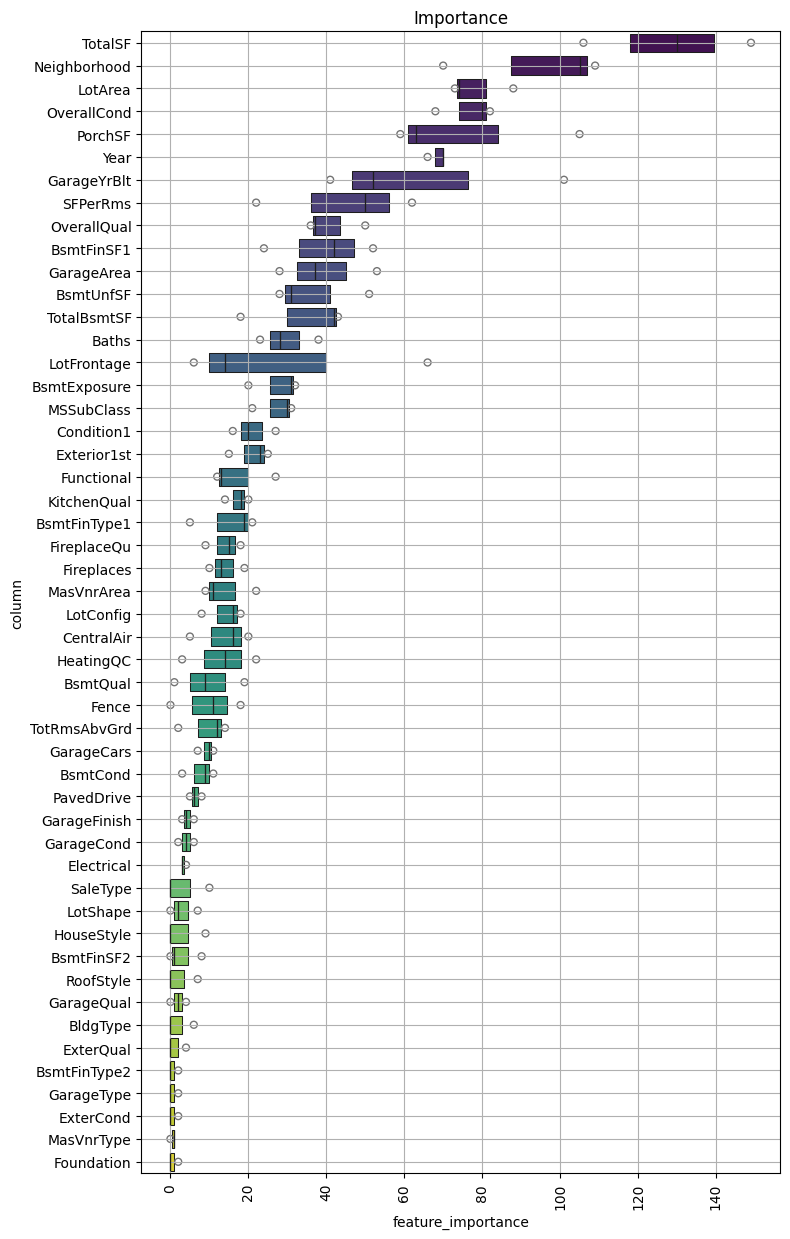

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns


def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importance()
        _df["column"] = pd.Series(feat_train_df.columns)
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = (
        feature_importance_df.groupby("column")
        .sum()[["feature_importance"]]
        .sort_values("feature_importance", ascending=False)
        .index[:50]
    )

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * 0.25)))
    sns.boxenplot(
        data=feature_importance_df,
        x="feature_importance",
        y="column",
        order=order,
        ax=ax,
        palette="viridis",
        orient="h",
    )
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax


models = []
for fold in range(CFG.N_SPLIT):
    model = pickle.load(
        open(
            CFG.MODEL_DATA_PATH
            / f"{CFG.AUTHOR}_lightgbm_{CFG.target_col}_fold{fold + 1}_seed{CFG.SEED}_ver{CFG.VER}.pkl",
            "rb",
        )
    )
    models.append(model)

fig, ax = visualize_importance(models, feat_train_df)

## Plot of predictions

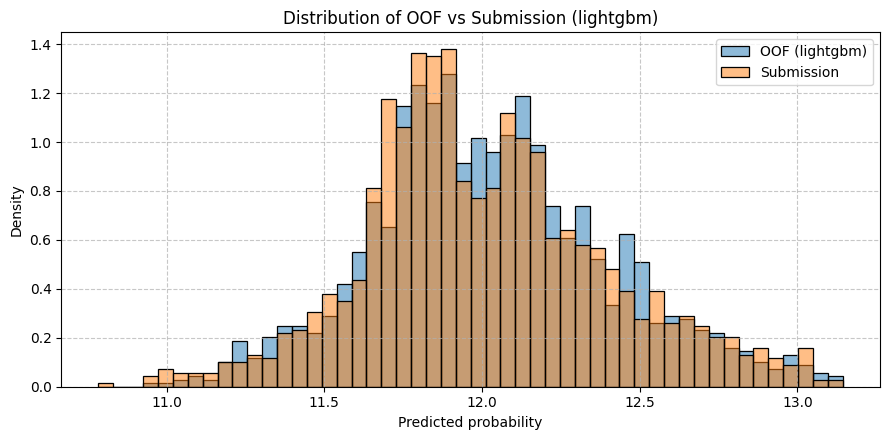

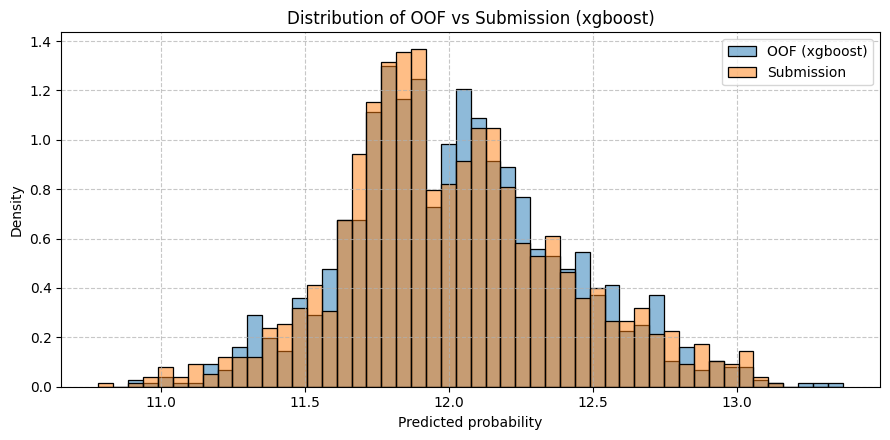

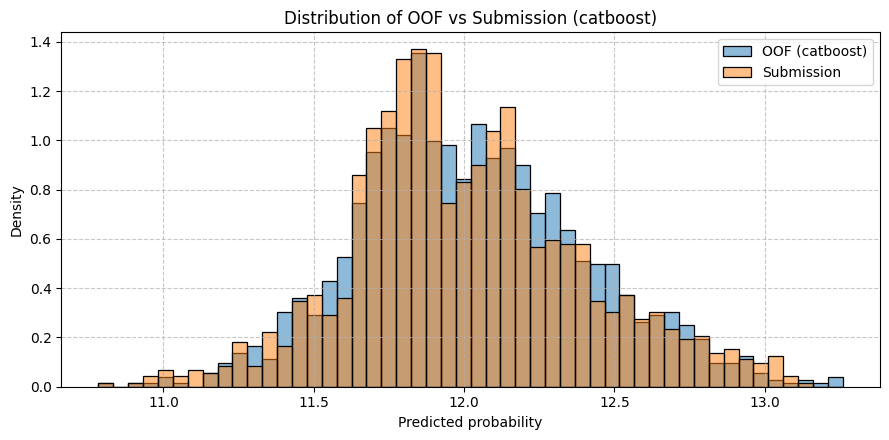

In [62]:
def plot_oof_vs_submission_hist(method_list, submission_df, bins=30):
    # 変換
    test_y = np.log1p(submission_df[CFG.target_col])

    for m in method_list:
        oof_path = CFG.OOF_DATA_PATH / f"oof_{CFG.AUTHOR}_{m}_seed{CFG.SEED}_ver{CFG.VER}.csv"
        oof_df = pd.read_csv(oof_path)

        # 両方の分布から min / max を決定
        lo = min(test_y.min(), oof_df[CFG.target_col].min())
        hi = max(test_y.max(), oof_df[CFG.target_col].max())
        bin_edges = np.linspace(lo, hi, bins + 1)

        # 可視化
        plt.figure(figsize=(9, 4.5))
        sns.histplot(
            oof_df[CFG.target_col],  #
            label=f"OOF ({m})",
            stat="density",
            bins=bin_edges,
            alpha=0.5,
        )
        sns.histplot(test_y, label="Submission", stat="density", bins=bin_edges, alpha=0.5)
        # plt.xlim(0, 1)
        plt.xlabel("Predicted probability")
        plt.ylabel("Density")
        plt.title(f"Distribution of OOF vs Submission ({m})")
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.tight_layout()
        plt.show()


plot_oof_vs_submission_hist(CFG.METHOD_LIST, submission_df, bins=50)

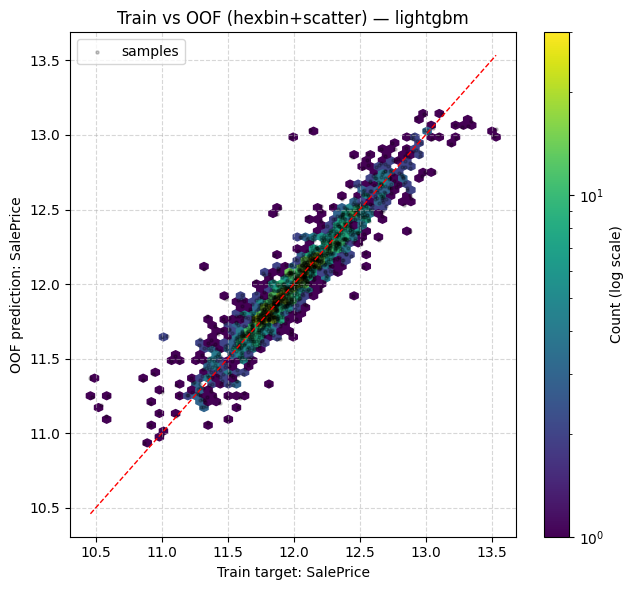

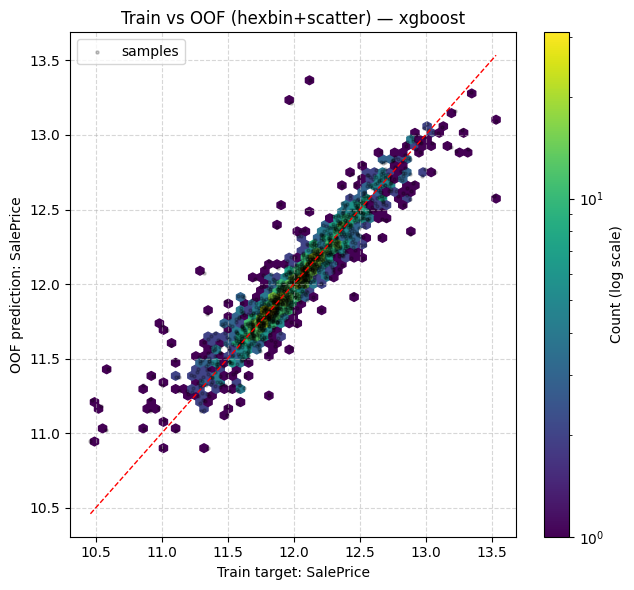

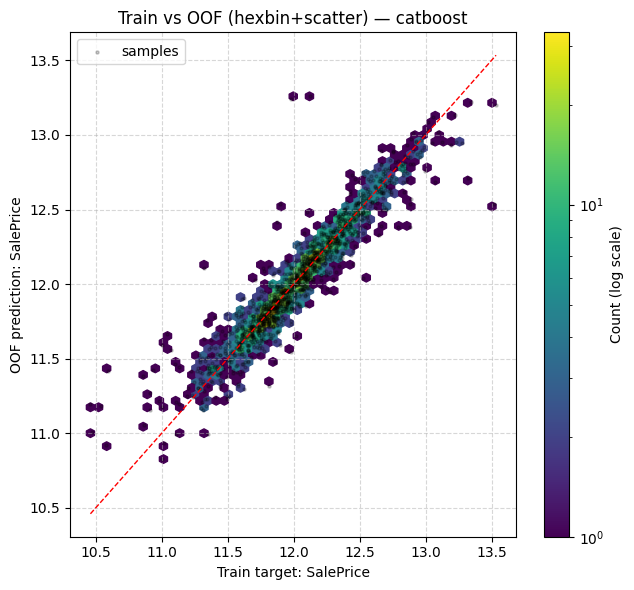

In [63]:
from matplotlib.colors import LogNorm


def plot_train_vs_oof_hexbin(method_list, train_df, bins=30, log1p=True, oof_value_col=None):
    """
    Train の目的変数 vs OOF予測 を 2D hexbin + scatter で可視化
    - hexbin は LogNorm を使い、少ない点も見やすくする
    - scatter を重ねて個別点も見えるようにする
    """
    y_true = train_df[CFG.target_col].dropna().to_numpy()

    for m in method_list:
        oof_path = CFG.OOF_DATA_PATH / f"oof_{CFG.AUTHOR}_{m}_seed{CFG.SEED}_ver{CFG.VER}.csv"
        oof_df = pd.read_csv(oof_path)

        col = oof_value_col if oof_value_col is not None else CFG.target_col
        if col not in oof_df.columns:
            raise KeyError(f"OOFファイルに列 '{col}' が見つかりません: {oof_path}")

        y_oof = oof_df[col].dropna().to_numpy()
        if len(y_true) != len(y_oof):
            raise ValueError(f"train({len(y_true)}) と OOF({len(y_oof)}) の長さが一致しません。")

        if log1p:
            y_true = np.log1p(y_true)
            y_oof = np.log1p(y_oof)

        # Hexbin + Scatter
        plt.figure(figsize=(6.5, 6))
        hb = plt.hexbin(y_true, y_oof, gridsize=bins, mincnt=1, cmap="viridis", norm=LogNorm())
        plt.scatter(y_true, y_oof, s=5, c="black", alpha=0.2, label="samples")

        cb = plt.colorbar(hb)
        cb.set_label("Count (log scale)")

        # 対角線
        lo = min(y_true.min(), y_oof.min())
        hi = max(y_true.max(), y_oof.max())
        plt.plot([lo, hi], [lo, hi], linestyle="--", linewidth=1, color="red")

        xlabel = f"{CFG.target_col} (log1p)" if log1p else CFG.target_col
        plt.xlabel(f"Train target: {xlabel}")
        plt.ylabel(f"OOF prediction: {xlabel}")
        plt.title(f"Train vs OOF (hexbin+scatter) — {m}")
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.tight_layout()
        plt.show()


plot_train_vs_oof_hexbin(CFG.METHOD_LIST, train_df, bins=50, log1p=False)